# Monte Carlo Techniques

## A quick reminder about what Monte Carlo is...

Monte Carlo techniques are often invoked when we need to do repeated sampling to detemine results. Often that means that the problem cannot be simply solved mathematically. For instance, when the effect of one step in the calculation changes the possibilities in the next steps. Let's look at the canonical, and simple, example of trying to predict the weather in a simple manner.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

**How often will it be sunny?**

Let's start by creating a transition matrix, which measures "given my current state, what's the probability that the state tomorrow will be X?" So for now let's say state 0 = Sunny and state 1 = Rainy. Our transition matrix will be 2x2, with the first row measuring "given that it's sunny right now, what's the probability that tomorrow will be sunny or rainy?" The second row will be the same, but for rainy.

This isn't implicitly easy to see what the "steady state" for sunny-ness will be. Depending on whether we roll a sunny or a rainy on the first day, the odds on the second day change. Depending what we roll on the second day, the third day will have different odds. So what we need to do is do a lot of sampling and see what our "average sunniness" will be.

In [2]:
transition_matrix=[[0.8,0.2],[0.5,0.5]]
average_sunniness = []

current_weather = 1 # start on a sunny day!

def check_weather(transition_matrix, current_weather=0):
    daily_weather_log = []
    for _ in range(10000):
        current_weather = np.random.choice([0,1], p=transition_matrix[current_weather])
        daily_weather_log.append(current_weather)
        average_sunniness.append(round(1. - np.mean(daily_weather_log),3))

    return round(1. - np.mean(daily_weather_log),3) # average sunniness

print(check_weather(transition_matrix))

0.708


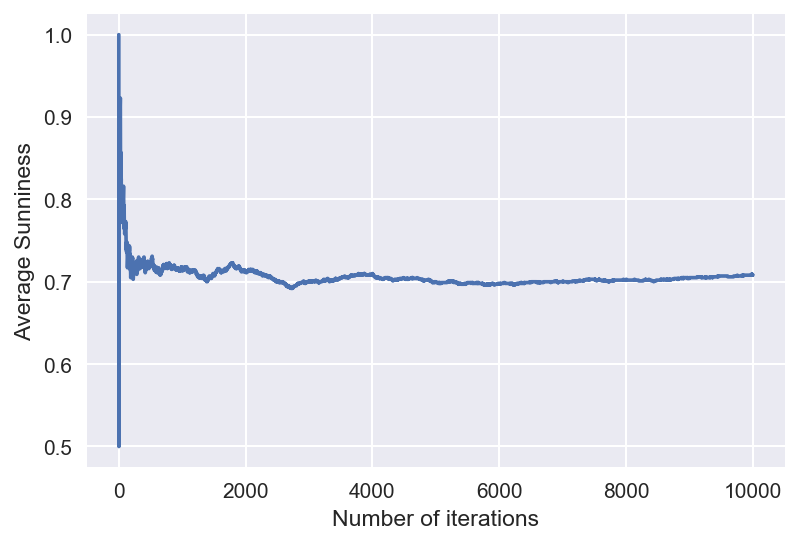

In [3]:
plt.figure(dpi=150)
plt.plot(range(len(average_sunniness)), average_sunniness);
plt.xlabel("Number of iterations")
plt.ylabel("Average Sunniness");

0.715


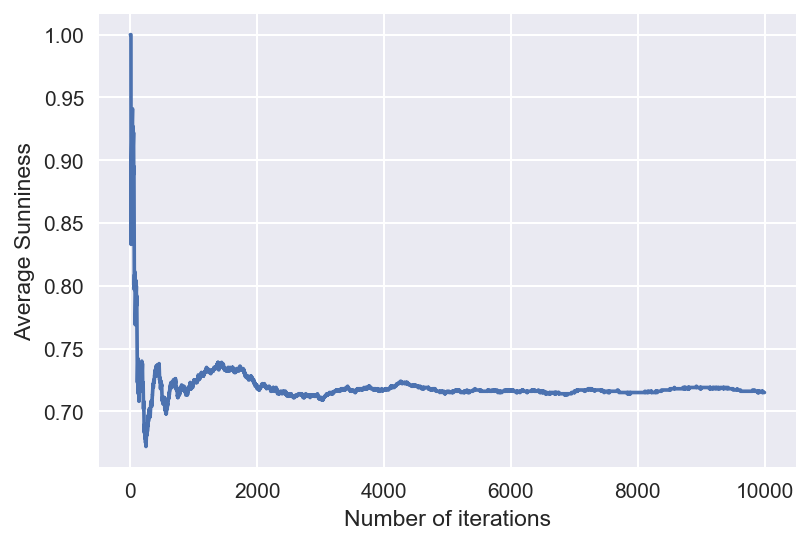

In [4]:
average_sunniness = []
print(check_weather(transition_matrix, current_weather=1))
plt.figure(dpi=150)
plt.plot(range(len(average_sunniness)), average_sunniness);
plt.xlabel("Number of iterations")
plt.ylabel("Average Sunniness");

By employing our random sampling technique, we can see that it's sunny ~71% of the days given those probabilities! That's not too intuitive since the average transition to sunniness is 65%, but because the sunny-to-sunny transition helps dominate, we see it tick up a bit higher. We also see that after enough running, the initial state doesn't matter any more. If we only did 5 samples, there would be a divergence based on which state we started in. With a long enough sampling, we'll converge to a true "steady state" of how sunny it is on average.

That's all well and good, but that's a pretty simple example. Let's get a bit deeper into how this can help.

# Particle Tracking in Nuclear Physics

One of the most challenging aspects of particle physics is knowing how to build a detector to find nearly weightless, super fast particles. To do that, we need to know things like, "if a particle that weights `m` is going at speed `v` what type of interactions will it have with my detector?" All of this comes back to a famous experiment called the **Rutherford Scattering** experiment. In this experiment, Rutherford shot some particles into a piece of gold and noticed that some of the particles bounced backwards. This is because solid materials are made up of hard nuclei on a grid like so (courtesy 123RF)

![Gold Lattice](https://previews.123rf.com/images/bond80/bond800903/bond80090300095/4526933-Crystal-lattice-consist-of-gold-spheres-and-silver-ties-Stock-Photo.jpg)

So when a particle is shot into a solid, there's some probability of bouncing off of a nucleus, and some probability of passing through. This probability changes if a particle we shoot is going slower or faster - and every time it bounces off of something the speed changes (it doesn't have to be a full on collision where it stops dead). That makes knowing how the particle will behave VERY hard - and a prime candidate for Monte Carlo.

Today we're going to build a class to put layers of different materials with different interaction probabilities together, then shoot some particles into it and see what happens! For simpicity, we'll assume the particles can only move in 1D.

In [62]:
class particle_monte_carlo:
    
    def __init__(self, random_state=None):
        self.total_width = 0.
        self.num_layers = 0.
        self.layers = {} # We'll store our materials here.
        self.colors = iter('rbygcmrbygcmrbygcmrbygcm')
        if random_state and type(random_state) == int:
            np.random.seed(random_state)
    
    def add_layer(self, width, scattering_probability, power_min, power_max):
        """
        Every layer is defined by how wide it is, the scattering probability 
        (how often a particle in that material will bounce), and how strong
        the scattering is (how much speed will the particle lose when it
        bounces). We'll label the layers in a dictionary by their start and
        end points in X.
        """
        self.layers[(self.total_width, self.total_width+width)] = (scattering_probability, power_min, power_max, next(self.colors))
        self.total_width += width
        self.num_layers += 1
        
    def shoot_particle(self, velocity = 1., return_hits=False, return_survival=False):
        """
        We shoot in a particle with speed = velocity. That particle takes a step that is
        x += speed, and if it's in a material, we then roll a dice to see if it interacts.
        If it does, then we remove some speed from the particle based on the strength
        of the layers' scattering power.
        
        At the end we can return either "did the particle survive to the end of the
        materials", "where did the particle bounce", or "what is the speed and position
        of the particle when it dies (or leaves the materials). We'll use all of these
        to analyze the results
        """
        x = 0
        time = 0
        hits = []
        while velocity > 0 and x < self.total_width:
            time += 0.01
            x += velocity*time
            current_layer = None
            for region, scattering in self.layers.items():
                if x > region[0] and x <= region[1]:
                    current_layer = scattering[0]
                    power_min = scattering[1]
                    power_max = scattering[2]
                    break

            if current_layer:
                if np.random.uniform() < current_layer:
                    velocity -= np.random.uniform(power_min, power_max) 
                    if return_hits:
                        hits.append(x)

        if x > self.total_width:
            x = self.total_width
        
        if return_hits:
            if x != hits[-1]:
                hits.append(x)
            return hits
        
        elif return_survival:
            if x == self.total_width:
                return 1
            else:
                return 0

        return (x, velocity)
    
    def plot_layers(self, return_ax = False, show_scatter_probs = False):
        """
        This function draws out our materials so we can see what they look
        like and how they're behaving with the particle
        """
        plt.figure(dpi=150)
        ax = plt.gca()
        ax.set_yticks([])
        title = "Composition of Target"
        for layer, data in self.layers.items():
            x_start = layer[0]
            width = layer[1] - layer[0]
            color = data[3]
            ax.add_patch(patches.Rectangle((x_start,0.25),width,0.5, color=color))
            if show_scatter_probs:
                plt.annotate(xy=(x_start+width/2-0.2, 0.5), s=str(data[0]), color='w')
                
        plt.xlim(0,self.total_width)
        plt.xlabel("Distance")
        if show_scatter_probs:
            title += " with Scattering Probabilities"
        plt.title(title)
        if return_ax:
            return ax

With the class made, let's first do some visualization of what's happening. We'll add 5 layers, each with a different width and scattering strength. Then we'll shoot some particles in and record where the particles bounce. The first step is always "starting_velocity*time" but after that depending on whether there's a bounce, an infinite number of other endings are possible! In this example, the black dots are interactions and the black X is where the particle ended. If it's on the far right, it survived!

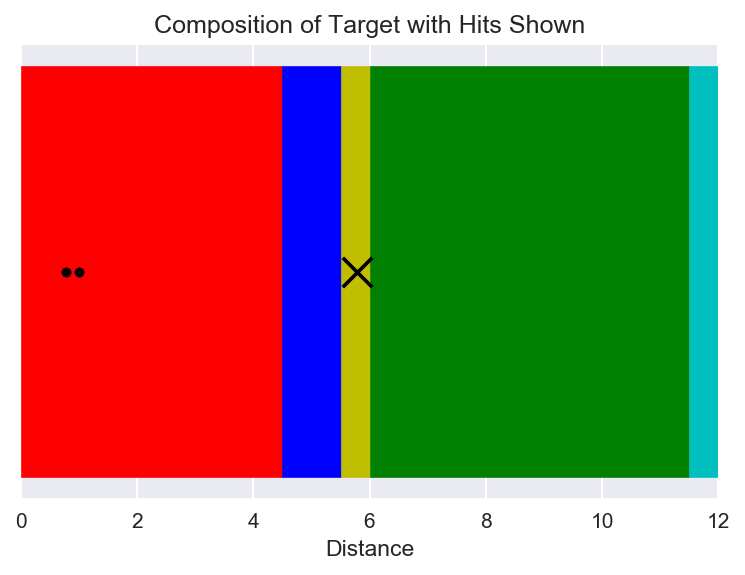

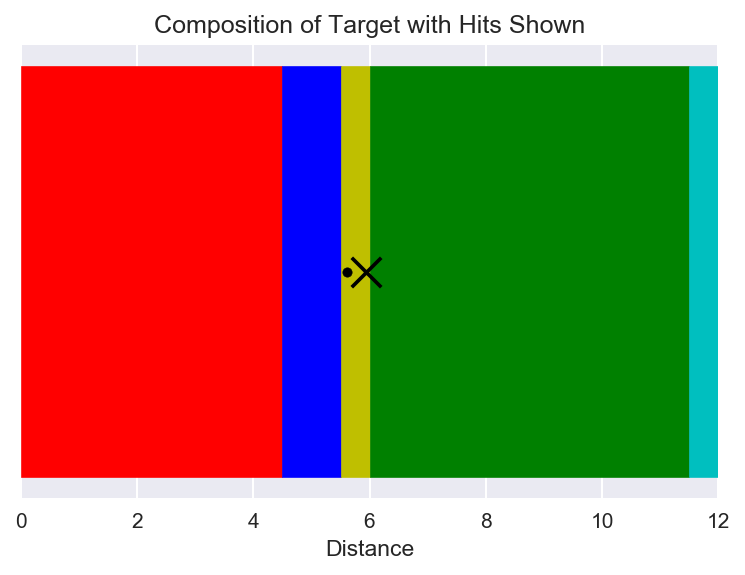

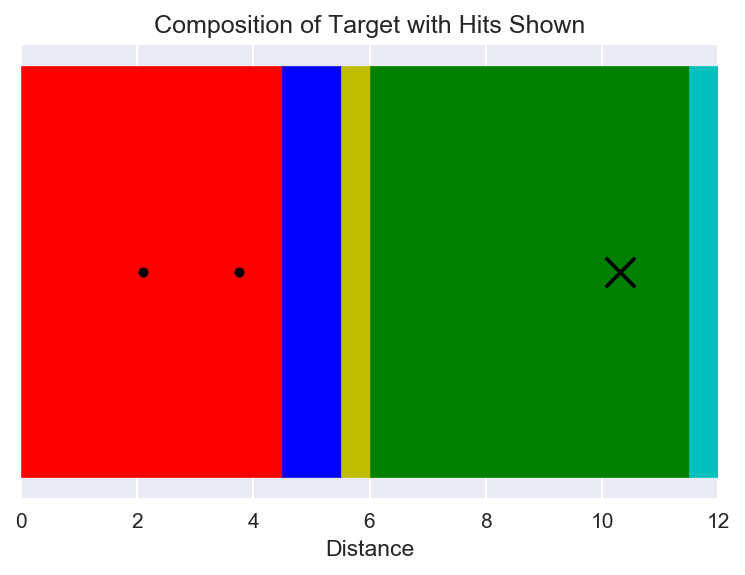

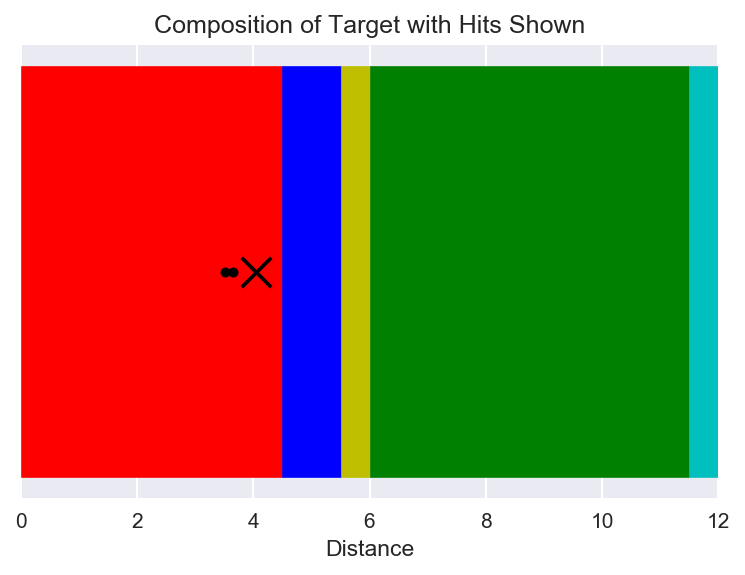

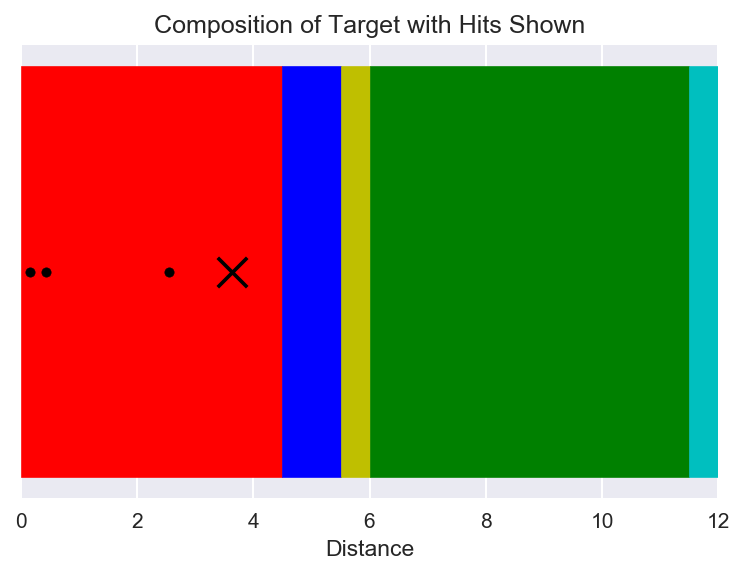

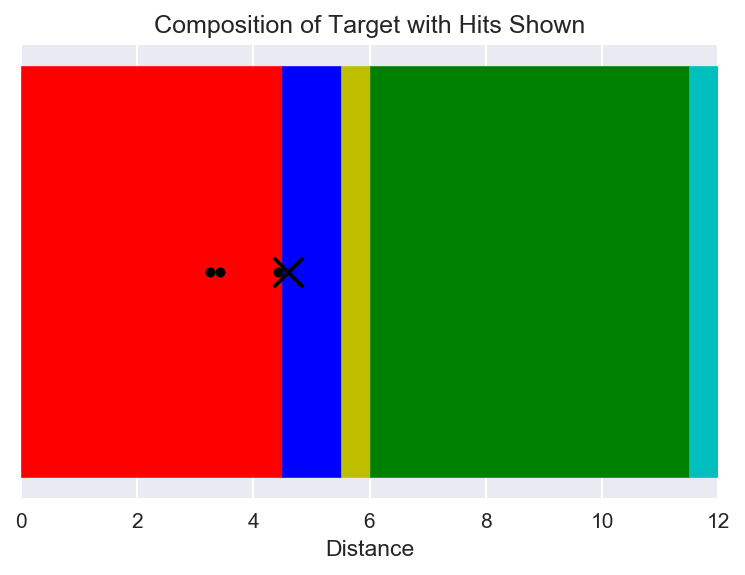

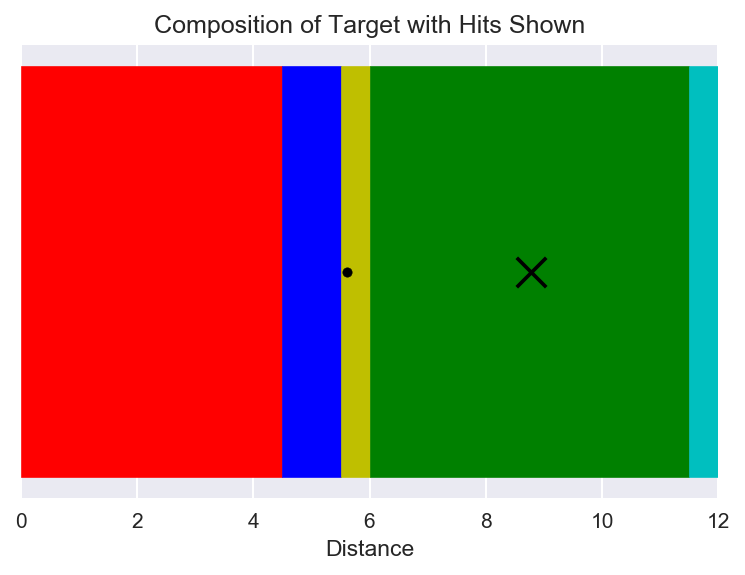

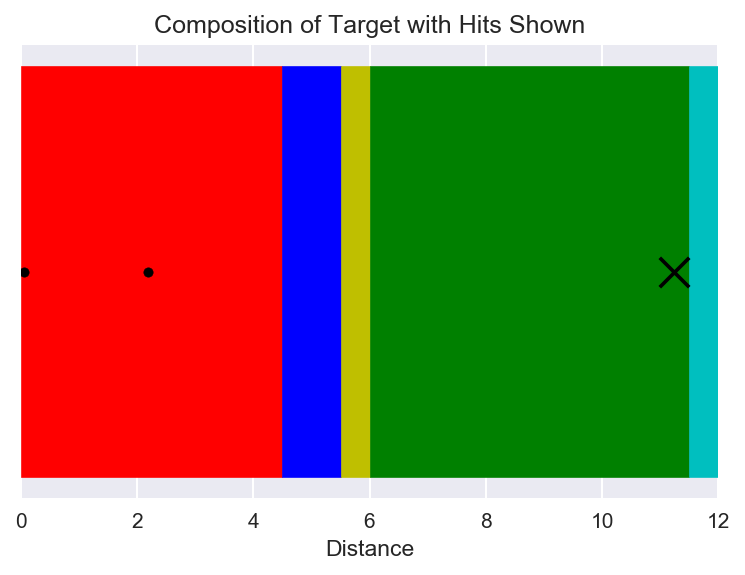

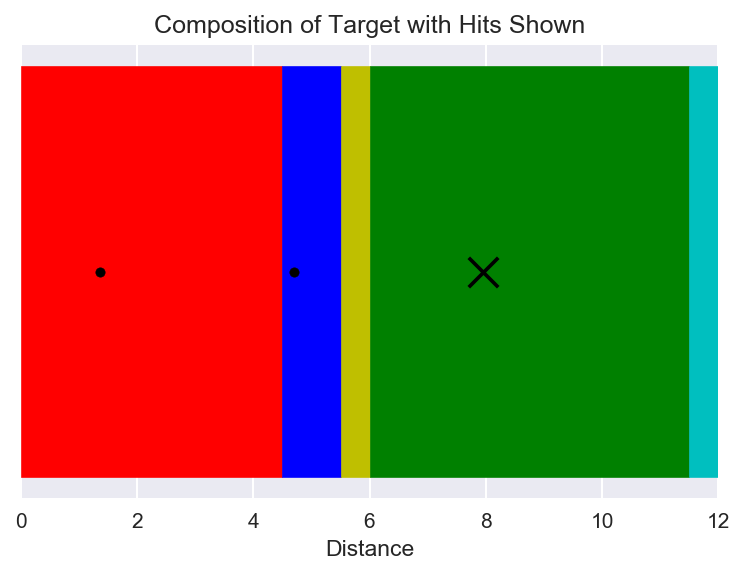

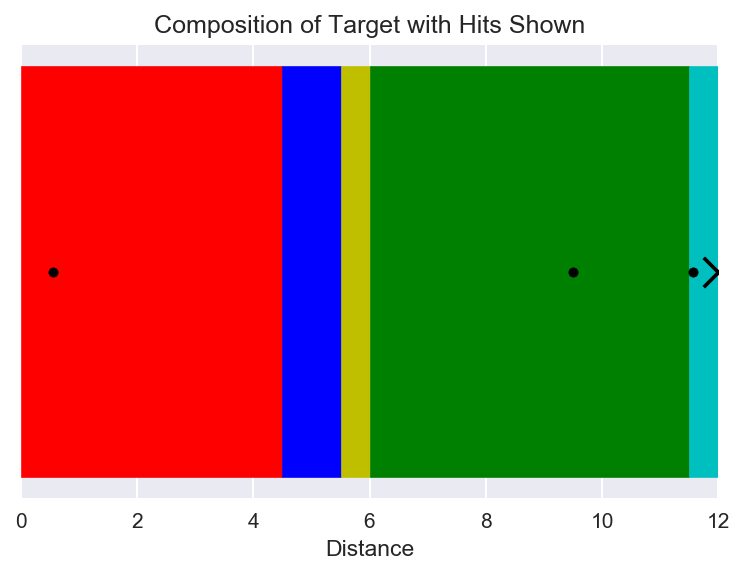

In [71]:
import matplotlib.patches as patches

blocks = particle_monte_carlo()
blocks.add_layer(4.5, 0.05, 0.1, 0.5)
blocks.add_layer(1., 0.1, 0.1, 0.2)
blocks.add_layer(0.5, 0.25, 0.5, 1)
blocks.add_layer(5.5, 0.1, 0.4, 0.9)
blocks.add_layer(0.5, 0.05, 0.1, 0.2)

num_plots = 10

for _ in range(num_plots):
    blocks.plot_layers()
    hits = blocks.shoot_particle(velocity=1,return_hits=True)
    plt.scatter(hits[:-1],[0.5 for _ in hits[:-1]],marker='o',c='k', s=20, zorder=10);
    plt.scatter(hits[-1],[0.5], marker='x',s=200,c='k',zorder=10);
    plt.title("Composition of Target with Hits Shown");

Great! It looks like our particles can interact all over the place, and whenver they lose all their speed, we say they're dead. Now let's actually do some analysis. 

One of the things physicists are most interested in is: what's the probability of survival given the particles speed (or energy). This tells us a lot about how interactive a material is. For simple materials, this is a little challenging... but it becomes even more challenging when we stack two different materials together. 

Think about the below: what do you think the probability of surviving is, given two layers: one with a 10% chance of scattering and one with a 5% chance of scattering? (hint, it depends on the starting speed)

Let's see if you're right.

In [77]:
b = particle_monte_carlo()

In [78]:
b.add_layer(1, 0.1, 0.5, 1)
b.add_layer(2, 0.05, 0.2, 1)

In [79]:
b.layers

{(0.0, 1.0): (0.1, 0.5, 1, 'r'), (1.0, 3.0): (0.05, 0.2, 1, 'b')}

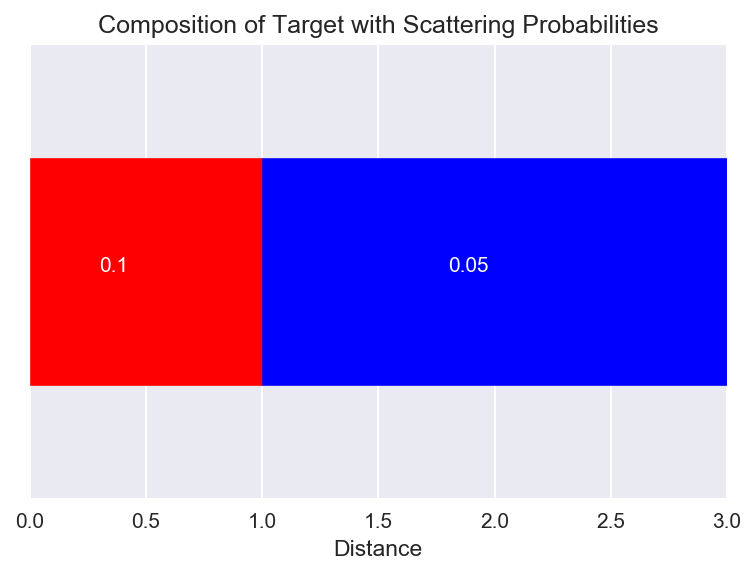

In [80]:
b.plot_layers(show_scatter_probs=True)

Let's generate 100 particles at each speed and look at all the different final speeds. 

In [88]:
results = []
starting_velocs = []
for v in np.linspace(0.1,2,100):
    for _ in range(100):
        starting_velocs.append(v)
        results.append(b.shoot_particle(velocity=v))

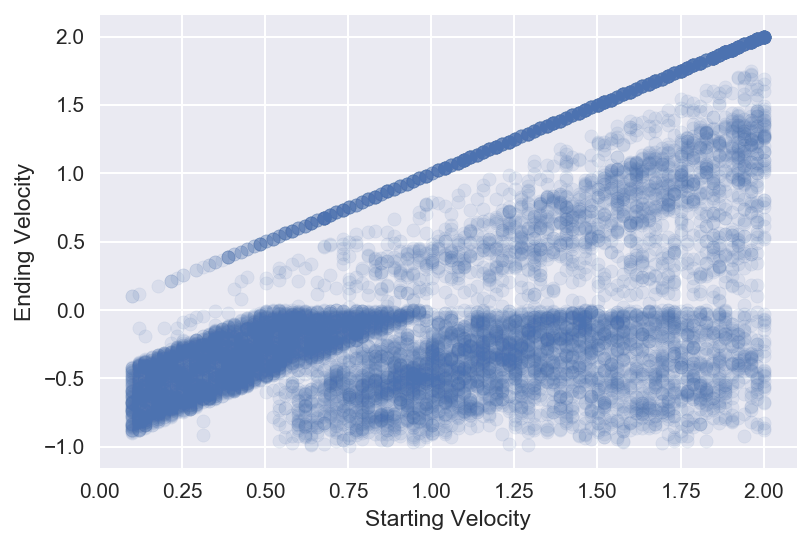

In [91]:
xs, final_velocs = zip(*results)
plt.figure(dpi=150)
plt.scatter(starting_velocs, final_velocs, s=40, alpha=0.1);
plt.xlabel("Starting Velocity")
plt.ylabel("Ending Velocity");

Now let's look at the final position vs the starting speed. This is called a "phase space" in the biz... it shows us how many possibilities we've explored. You can see that as the speed goes up, it becomes more likely to make it to the end of the track! We also see that in the low starting speed region, there are some places where it's very unlikely for the particle to end (like a starting velocity of 0.25 and and ending position of 2.5).

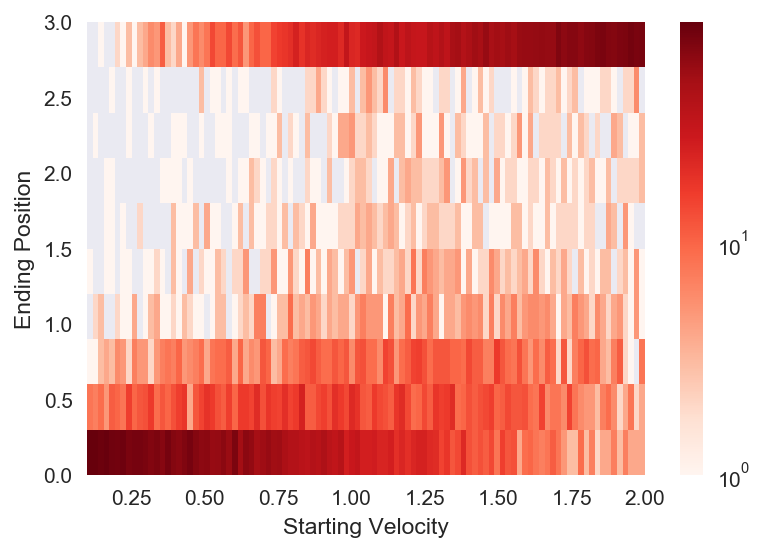

In [83]:
from matplotlib.colors import LogNorm
plt.figure(dpi=150)
plt.ylabel("Ending Position")
plt.xlabel("Starting Velocity");
plot_x = xs
plt.hist2d(starting_velocs,plot_x, cmap=plt.cm.Reds, bins=(100,10), norm=LogNorm());
plt.grid(False)
plt.colorbar();

Let's also look at the possible stopping positions as a histogram, to see what our output states look like for a starting speed!

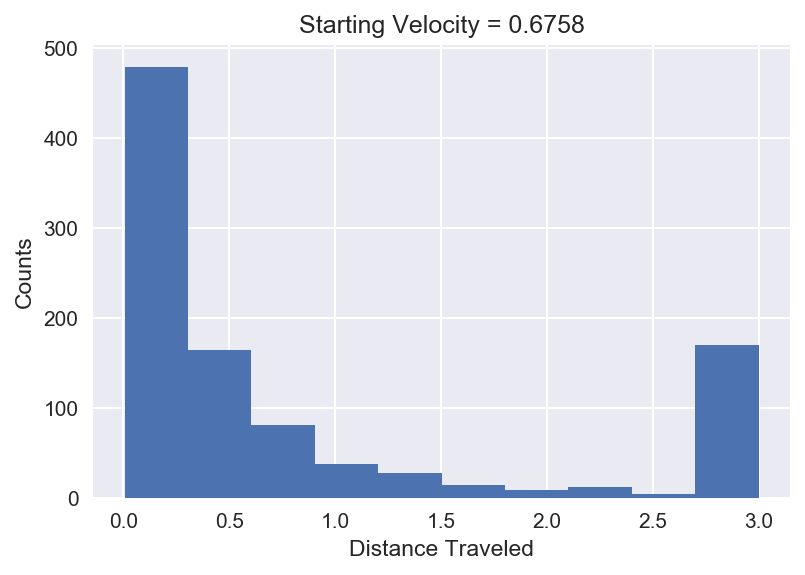

In [84]:
plt.figure(dpi=150)
plt.hist(xs[3000:4000]);
plt.title("Starting Velocity = "+str(round(starting_velocs[3000],4)))
plt.xlabel("Distance Traveled")
plt.ylabel("Counts");

Alright, now that we can see how the system is behaving. Let's actually measure the survival rate vs starting velocity.

In [85]:
starting_velocs = []
survival_rate = []
for v in np.linspace(0.1,2.5,200):
    results = []
    for _ in range(5000):
        results.append(b.shoot_particle(velocity=v, return_survival=True))
    survival_rate.append((v, np.sum(results)/len(results)))

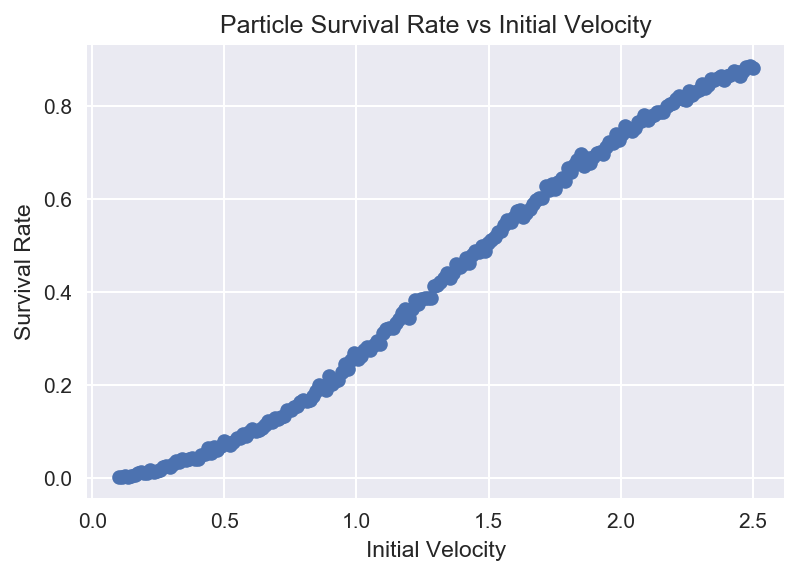

In [86]:
vs, surv_rate = zip(*survival_rate)
plt.figure(dpi=150)
plt.plot(vs, surv_rate,'--o', lw=0.5);
plt.xlabel("Initial Velocity")
plt.ylabel("Survival Rate");
plt.title("Particle Survival Rate vs Initial Velocity");

 Nice, this confirms what we were seeing above - as the speed goes up, so does the survival rate. However, it doesn't go up in a nice linear fashion, it has this sort of "turning on" section around 0.75. It's a shape we wouldn't have been able to easily guess just by knowing the blocks we have. That's really neat!
 
 **What about with a more complicated system of materials?**

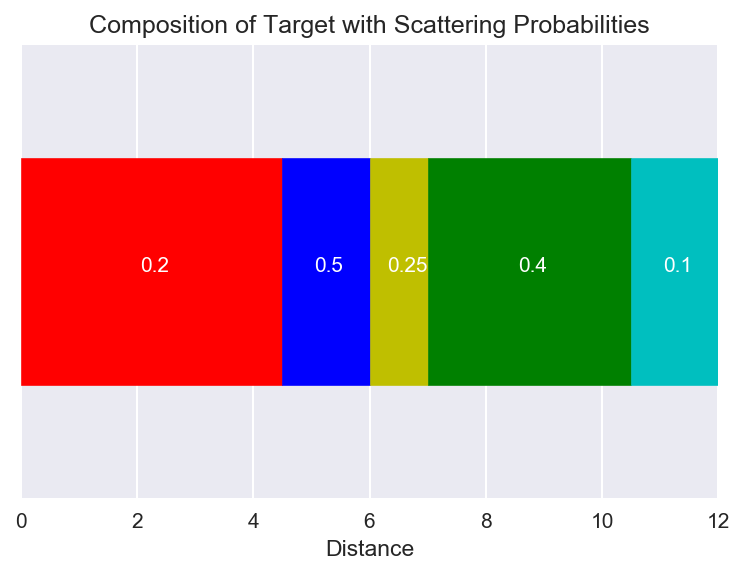

In [59]:
b = particle_monte_carlo()
b.add_layer(4.5, 0.2, 0.1, 0.5)
b.add_layer(1.5, 0.5, 0.1, 0.2)
b.add_layer(1.0, 0.25, 0.05, 0.1)
b.add_layer(3.5, 0.4, 0.4, 0.9)
b.add_layer(1.5, 0.1, 0.1, 0.2)
b.plot_layers(show_scatter_probs=True)

In [60]:
starting_velocs = []
survival_rate = []
for v in np.linspace(0.1,2.5,200):
    results = []
    for _ in range(10000):
        results.append(b.shoot_particle(velocity=v, return_survival=True))
    survival_rate.append((v, np.sum(results)/len(results)))

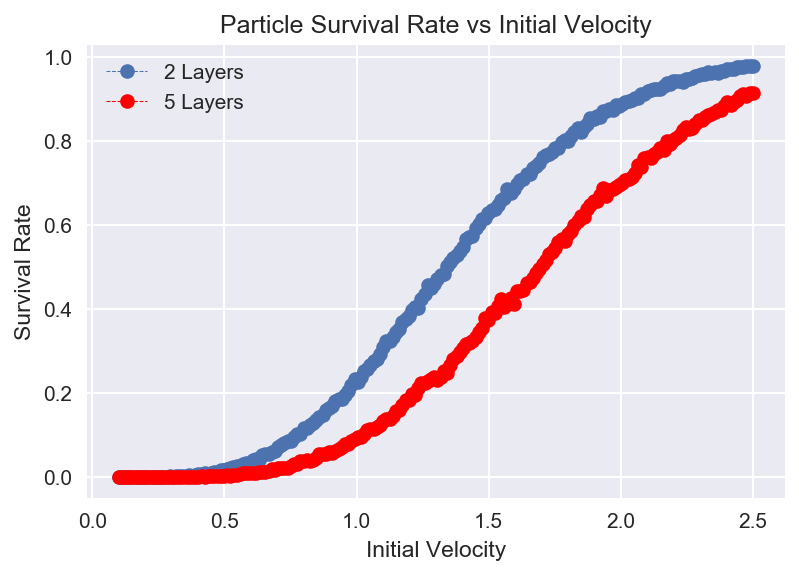

In [61]:
vs2, surv_rate2 = zip(*survival_rate)
plt.figure(dpi=150)
plt.plot(vs, surv_rate,'--o', lw=0.5, label='2 Layers');
plt.plot(vs2, surv_rate2,'--or', lw=0.5, label='5 Layers');
plt.xlabel("Initial Velocity")
plt.ylabel("Survival Rate");
plt.title("Particle Survival Rate vs Initial Velocity");
plt.legend(loc="upper left");

With the more complicated system, we see that the scattering is much more likely to slow down the particles and it makes a faster starting speed "required" if you want to be likely to survive. With teh 5 layer system, we have significantly less survival of particles at pretty much every speed. We also see that we have a very different shape of our survival curve.

All of this would be totally uncalculable without Monte Carlo. There's nothing about this system of blocks that tells us what this shape should be. We simply HAVE to simulate it. 

Physicsists do this all the time. Instead of writing blocks of material with some scattering probability, they usually program in things like the scattering cross-section for a material. It is essentially the same thing as our scattering probability, just written a bit more precisely and with a bit more useful material tucked into it. It's the exact same process though. In fact, physicists in particle and nuclear physics do this so often they have entire software packages dedicated just to simulating things in this exact manner. You can check out GEANT, Pythia, and many other Monte Carlo particle generators and trackers.